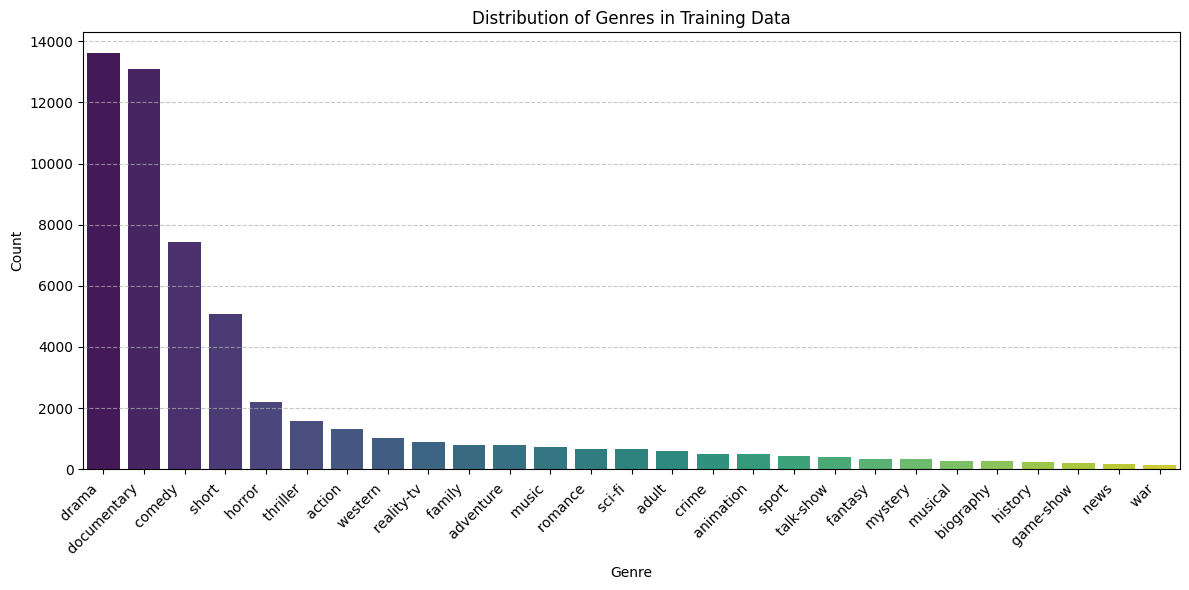


Training Logistic Regression...


In [ ]:
# 1. IMPORT LIBRARIES

import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# 2. LOAD DATASETS

train_path = r"C:\Users\HP\Downloads\archive (1)\Genre Classification Dataset\train_data.txt"
test_path = r"C:\Users\HP\Downloads\archive (1)\Genre Classification Dataset\test_data.txt"
test_solution_path = r"C:\Users\HP\Downloads\archive (1)\Genre Classification Dataset\test_data_solution.txt"

train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_solution = pd.read_csv(test_solution_path, sep=":::", names=['Id', 'Title', 'Gener', 'Description'], engine="python")


# 3. GENRE DISTRIBUTION

genre_counts = train_data['Genre'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Genres in Training Data')
plt.xlabel('Genre'); plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show(block=False)   
plt.pause(150)          
plt.close()             


# 4. TEXT CLEANING

stemmer = LancasterStemmer()
stop_words = set(stopwords.words("english"))

def cleaning_data(text):
    text = str(text).lower()
    text = re.sub(r'@\S+|http\S+|.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)        # keep only alphabets
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_data['clean_description'] = train_data['Description'].apply(cleaning_data)
test_data['clean_description'] = test_data['Description'].apply(cleaning_data)
test_solution['clean_description'] = test_solution['Description'].apply(cleaning_data)

# 5. LABEL ENCODING

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['Genre'])
X = train_data['clean_description']

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. PIPELINES FOR LOGISTIC & SVM

logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))),
    ('model', LogisticRegression(max_iter=1000, random_state=0))
])


svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))),
    ('model', SVC(kernel='linear', C=1))
])

# 7. TRAIN BOTH MODELS

print("\nTraining Logistic Regression...")
logreg_pipeline.fit(X_train, y_train)
y_val_pred_logreg = logreg_pipeline.predict(X_val)
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_val_pred_logreg))
print(classification_report(y_val, y_val_pred_logreg, target_names=label_encoder.classes_))

print("\nTraining SVM...")
svm_pipeline.fit(X_train, y_train)
y_val_pred_svm = svm_pipeline.predict(X_val)
print("SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm, target_names=label_encoder.classes_))

# 8. EVALUATE ON TEST DATA

def evaluate_on_test(pipeline, test_data, test_solution, model_name):
    test_predictions = pipeline.predict(test_data['clean_description'])
    test_predictions_labels = label_encoder.inverse_transform(test_predictions)
    test_data_temp = test_data[['Id']].copy()
    test_data_temp['Predicted_Gener'] = test_predictions_labels
    
    comparison_df = test_data_temp.merge(test_solution[['Id', 'Gener']], on='Id')
    accuracy = accuracy_score(comparison_df['Gener'], comparison_df['Predicted_Gener'])
    print(f"{model_name} Test Accuracy: {accuracy}")
    return comparison_df

print("\n--- Test Data Evaluation ---")
comparison_logreg = evaluate_on_test(logreg_pipeline, test_data, test_solution, "Logistic Regression")
comparison_svm = evaluate_on_test(svm_pipeline, test_data, test_solution, "SVM")